In [1]:
from __future__ import division
from importlib import reload
from modules import * 
fig_savedir = '../data/figures/'

grid_params = {
    'y_height':   20,
    'x_width':    20,
    'walls':      False,
    'rho':        0,
    'maze_type':  'none',
    'port_shift': 'none'
}


agent_params = {
    'load_model':   True,
    'load_dir':     '../data/outputs/gridworld/MF{}{}training.pt'.format(grid_params['x_width'],grid_params['y_height']),
    'action_dims':  6, #=len(maze.actionlist)
    'batch_size':   1,
    'gamma':        0.98, #discount factor
    'eta':          5e-4,
    'temperature':  1,
    'use_EC':       False,
    'cachelim':     300, #int(0.75*np.prod(maze.grid.shape)) # memory limit should be ~75% of #actions x #states
    'state_type':   'conv'
}

run_dict = {
    'NUM_EVENTS':   150,
    'NUM_TRIALS':   5000,
    'print_freq':   1/10,
    'total_loss':   [[],[]],
    'total_reward': [],
    'val_maps':     [],
    'policies':     [{},{}],
    'deltas':       [],
    'spots':        [],
    'vls':          []
}

In [2]:
#make environment
maze = eu.gridworld(grid_params)
maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
env = eu.gymworld(maze) # openAI-like wrapper 

#update agent params dictionary with layer sizes appropriate for environment 
agent_params = sg.gen_input(maze, agent_params)

MF,opt = ac.make_agent(agent_params)

EC = ec.ep_mem(MF,agent_params['cachelim']) 

/home/annik/.local/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/annik/.local/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/annik/.local/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object'

In [3]:
for i in agent_params:
    print(i, agent_params[i])
print('------')
for name, i in MF.named_parameters():
    print(name, i.shape)
print('------')
for i in MF.parameters():
    print(i.shape)

load_model True
load_dir ../data/outputs/gridworld/MF2020training.pt
action_dims 6
batch_size 1
gamma 0.98
eta 0.0005
temperature 1
use_EC False
cachelim 300
state_type conv
num_channels 3
input_dims (20, 20, 3)
hid_types ['conv', 'pool', 'linear']
hid_dims [(19, 19, 3), (18, 18, 3), 500]
------
hidden.0.weight torch.Size([3, 3, 4, 4])
hidden.0.bias torch.Size([3])
hidden.2.weight torch.Size([500, 972])
hidden.2.bias torch.Size([500])
actor.weight torch.Size([6, 500])
actor.bias torch.Size([6])
critic.weight torch.Size([1, 500])
critic.bias torch.Size([1])
------
torch.Size([3, 3, 4, 4])
torch.Size([3])
torch.Size([500, 972])
torch.Size([500])
torch.Size([6, 500])
torch.Size([6])
torch.Size([1, 500])
torch.Size([1])


In [4]:
# write a function for runs with episodic mem and without -- take use_EC as a param
# assume just for conv inputs 
def run_trials(run_dict, use_EC, **kwargs):
    save_data  = kwargs.get('save', True)
    NUM_TRIALS = run_dict['NUM_TRIALS']
    NUM_EVENTS = run_dict['NUM_EVENTS']

    if use_EC:
        add_mem_dict = {} #dictionary of items which get put into memory cache
        timestamp    = 0
        
        for trial in range(NUM_TRIALS):
            trialstart_stamp = timestamp

            reward_sum   = 0
            v_last       = 0
            track_deltas = []
            track_spots  = []
            visited_locs = []

            env.reset() 
            state = ac.Variable(ac.torch.FloatTensor(np.expand_dims(sg.get_frame(maze), axis=0)))
            MF.reinit_hid() #reinit recurrent hidden layers

            for event in range(NUM_EVENTS):
                # pass state through EC module
                policy_, value_ = MF(state, agent_params['temperature'])[0:2]
                add_mem_dict['state'] = maze.cur_state
                visited_locs.append(maze.cur_state)

                '''
                NEED TO USE CONFIDENCE SCORE HERE
                - track time since last reward
                - 
                
                '''
                
                choice, policy, value = ac.select_action(MF,policy_, value_)
                if event < NUM_EVENTS: 
                    next_state, reward, done, info = env.step(choice)

                MF.rewards.append(reward)
                delta = reward + agent_params['gamma']*value - v_last  #compute eligibility trace/rpe approximation

                add_mem_dict['activity']  = tuple(lin_act_.view(-1).data)
                add_mem_dict['action']    = choice
                add_mem_dict['delta']     = delta
                add_mem_dict['timestamp'] = timestamp            
                EC.add_mem(add_mem_dict, keep_hist = True)             #add event to memory cache

                if reward != 0:
                    EC.reward_update(trialstart_stamp, timestamp, reward)
                #EC.reward_update(trialstart_stamp, timestamp, delta[0])
                track_deltas.append(delta[0])
                track_spots.append(maze.cur_state)

                # because we need to include batch size of 1 
                frame = np.expand_dims(sg.get_frame(maze), axis = 0)
                state = ac.Variable(ac.torch.FloatTensor(frame))
                reward_sum += reward

                v_last = value
                timestamp += 1
                
            p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)

            if save_data:
                #value_map = ac.generate_values(maze,MF)
                run_dict['total_loss'][0].append(p_loss.data[0])
                run_dict['total_loss'][1].append(v_loss.data[0])
                run_dict['total_reward'].append(reward_sum)
                #run_dict['val_maps'].append(value_map.copy())
                #run_dict['deltas'].append(track_deltas)
                #run_dict['spots'].append(track_spots)
                #run_dict['vls'].append(visited_locs)

            if trial ==0 or trial%100==0 or trial == NUM_TRIALS-1:
                print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
                blocktime = time.time()


    else:
        for trial in range(NUM_TRIALS):
            reward_sum   = 0
            v_last       = 0
            track_deltas = []
            track_spots  = []
            visited_locs = []

            env.reset() 
            state = ac.Variable(ac.torch.FloatTensor(np.expand_dims(sg.get_frame(maze), axis=0)))
            MF.reinit_hid() #reinit recurrent hidden layers

            for event in range(NUM_EVENTS):
                policy_, value_ = MF(state, agent_params['temperature'])[0:2]
                choice, policy, value = ac.select_action(MF,policy_, value_)

                if event < NUM_EVENTS: 
                    next_state, reward, done, info = env.step(choice)

                MF.rewards.append(reward)
                delta = reward + agent_params['gamma']*value - v_last  #compute eligibility trace/rpe approximation
                state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))

                reward_sum += reward
                v_last = value

            p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)

            if save_data:
                #value_map = ac.generate_values(maze,MF)
                run_dict['total_loss'][0].append(p_loss.data[0])
                run_dict['total_loss'][1].append(v_loss.data[0])
                run_dict['total_reward'].append(reward_sum)
                #run_dict['val_maps'].append(value_map.copy())
                #run_dict['deltas'].append(track_deltas)
                #run_dict['spots'].append(track_spots)
                #run_dict['vls'].append(visited_locs)

            if trial ==0 or trial%100==0 or trial == NUM_TRIALS-1:
                print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
                blocktime = time.time()


In [11]:
a1 = run_trials(run_dict, False)


[18:01:11]  Trial 1 TotRew = 143 (0.343s)
[18:01:31]  Trial 101 TotRew = 133 (19.727s)
[18:01:49]  Trial 201 TotRew = 147 (18.270s)
[18:02:08]  Trial 301 TotRew = 139 (18.639s)
[18:02:29]  Trial 401 TotRew = 137 (21.220s)
[18:02:53]  Trial 501 TotRew = 141 (24.101s)
[18:03:16]  Trial 601 TotRew = 136 (23.124s)
[18:03:40]  Trial 701 TotRew = 142 (23.847s)
[18:04:03]  Trial 801 TotRew = 137 (22.647s)


KeyboardInterrupt: 

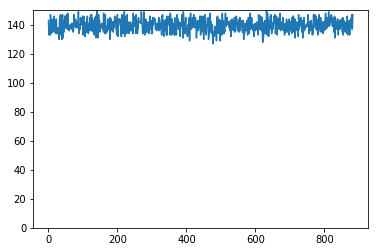

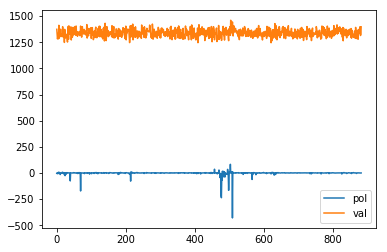

In [13]:
plt.figure(1)
plt.plot(run_dict['total_reward'])
plt.ylim([0,run_dict['NUM_EVENTS']])
 
plt.figure(2)
plt.plot(run_dict['total_loss'][0], label = 'pol')
plt.plot(run_dict['total_loss'][1], label = 'val')
plt.legend(loc=0)
plt.show()
plt.close()
#gp.print_value_maps(maze, run_dict['val_maps'], maps=0, val_range=(-1,50), save_dir=fig_savedir, title='Value Map')

In [6]:
ac.torch.save(MF,agent_params['load_dir'])